In [1]:
import zen
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import pandas as pd

In [11]:
def katz(G,tol=0.01,max_iter=1000,alpha=0.001,beta=1):
    iteration = 0
    centrality = np.zeros(G.num_nodes)
    while iteration < max_iter:
        iteration += 1          # increment iteration count
        centrality_old = centrality.copy()

        for node in G.nodes_():
            Ax = 0
            for neighbor in G.neighbors_(node):
                #weight = G.weight_(G.edge_idx_(neighbor,node))
                #Ax += np.multiply(centrality[neighbor],weight)

                Ax += centrality[neighbor]      #exclude weight due to overflow in multiplication

            centrality[node] = np.multiply(alpha,Ax)+beta

        if np.sum(np.abs(np.subtract(centrality,centrality_old))) < tol:
            return centrality

def modular_graph(Size1, Size2, edges1, edges2, common, katz_alpha=0.001):
    g1 = zen.generating.barabasi_albert(Size1,edges1)
    avgDeg1 = (2.0 * g1.num_edges)/g1.num_nodes
    #lcc1 = np.mean(zen.algorithms.clustering.lcc_(g1))
    d1 = g1.num_edges/((Size1*(Size1-1))/2.0)
    
    g2 = zen.generating.barabasi_albert(Size2,edges2)
    avgDeg2 = (2.0 * g2.num_edges)/g2.num_nodes
    #lcc2 = np.mean(zen.algorithms.clustering.lcc_(g2))
    d2 = g2.num_edges/((Size2*(Size2-1))/2.0)
    
    Size = Size1 + Size2
    G = zen.Graph()
    for i in range(Size):
        G.add_node(i)

    for edge in g1.edges_iter():
        u = edge[0]
        v = edge[1]
        G.add_edge(u,v)

    for edge in g2.edges_iter():
        u = edge[0]+Size1
        v = edge[1]+Size1
        G.add_edge(u,v)

    # Select random pairs of nodes to connect the subgraphs
    join_nodes = np.empty((common,2),dtype=np.int64)
    nodes1 = np.random.randint(0,Size1,size=common)
    nodes2 = np.random.randint(Size1,Size,size=common)
    join_nodes[:,0] = nodes1
    join_nodes[:,1] = nodes2

    for edge in join_nodes:
        if not G.has_edge(edge[0],edge[1]):
            G.add_edge(edge[0],edge[1])
    
    # Modularity Calculation
    classes = {0:np.arange(0,Size1),1:np.arange(Size1,Size)}
    Q = zen.algorithms.modularity(G,classes)

    # Maximum Modularity
    count=0.0
    for e in G.edges():
        if (e[0]<Size1 and e[1]<Size1) or (e[0]>=Size1 and e[1]>=Size1):
            count += 1
    same = count / G.num_edges
    rand = same - Q
    qmax = 1 - rand
    q_norm = Q/qmax
    
    evc = zen.algorithms.eigenvector_centrality_(G)
    kc = katz(G,alpha=katz_alpha)
    
    #return avgDeg1, avgDeg2, lcc1, lcc2, q_norm, evc, kc
    return avgDeg1, avgDeg2, d1, d2, q_norm, evc, kc

In [12]:
size1 = 300
size2 = 250
edge1 = 10
edge2 = 20
common_edges= 800
#avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
avgDeg1, avgDeg2, d1, d2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)

In [14]:
print "                     G1     |  G2"
print "Average Degree:      %.2f   |  %.2f"%(avgDeg1,avgDeg2)
#print "Avgerage Clustering: %.2f   |  %.2f"%(avgLcc1,avgLcc2)
print "Density:             %.4f   |  %.4f"%(d1,d2)
print ""
print "Modularity: %.2f"%mod

                     G1     |  G2
Average Degree:      19.33   |  36.80
Density:             0.0647   |  0.1478

Modularity: 0.80


In [15]:
def arc(x,r):
    return np.sqrt(np.power(r,2) - np.power(x,2))

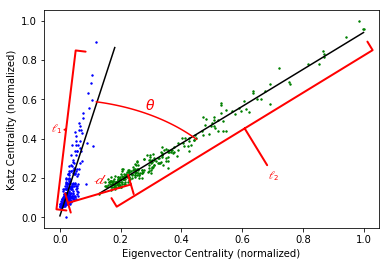

34.818 degrees between lines
median green evc: 0.26


In [16]:
evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
kc = (kc - np.min(kc)) / np.max(kc - np.min(kc))

evc1 = evc[np.arange(size1)]
evc2 = evc[np.arange(size2)+size1]
kc1 = kc[np.arange(size1)]
kc2 = kc[np.arange(size2)+size1]

m1, b1, _,_,_ = linregress(evc1,kc1)
m2,b2,_,_,_ = linregress(evc2,kc2)

xx1 = np.linspace(np.min(evc1),np.max(evc1),2)
xx2 = np.linspace(np.min(evc2),np.max(evc2),2)
yy1 = m1*xx1*1.5 + b1
yy2 = m2*xx2 + b2
#fig = plt.figure(figsize=(6,6))
plt.scatter(evc1,kc1,s=2,c='b')
plt.plot(xx1*1.5,yy1,c='k')
plt.scatter(evc2,kc2,s=2,c='g')
plt.plot(xx2,yy2,c='k')
plt.xlabel('Eigenvector Centrality (normalized)')
plt.ylabel('Katz Centrality (normalized)')
x = np.linspace(0.12,0.45,100)
y = arc(x,0.6)
plt.plot(x,y,c='r')
plt.text(0.28,0.55,r'$\theta$',fontsize=14,color='r')
X = np.mean(xx2)+0.04
Y = np.mean(yy2)-0.07
plt.gca().annotate(r'$\mathscr{l}_2$',color='r',xy=(X,Y),xytext=(X+0.08,(-1/m2)*0.08+Y-0.165),va='center',
                   arrowprops=dict(arrowstyle='-[,widthB=15, lengthB=1',lw=2.0,color='r'))
X = np.median(xx1)-0.04
Y = (np.max(kc1)-np.min(kc1))*0.5
plt.gca().annotate(r'$\mathscr{l}_1$',color='r',xy=(X,Y),xytext=(X-0.05,(-1/m1)*0.02+Y+0.01),va='center',
                   arrowprops=dict(arrowstyle='-[,widthB=8, lengthB=1',lw=2.0,color='r'))
plt.gca().annotate('',color='r',xy=(0.02,0.07),xytext=(0.24,0.17),
                  arrowprops=dict(arrowstyle='|-|,widthA=1,widthB=1',lw=2,color='r'))
plt.text(0.11,0.17,r'$\mathscr{d}$',fontsize=14,color='r')
plt.show()
print "%.3f degrees between lines"%(np.abs(np.arctan(m1) - np.arctan(m2))*180/np.pi)
print "median green evc: %.2f"%(np.median(evc2))

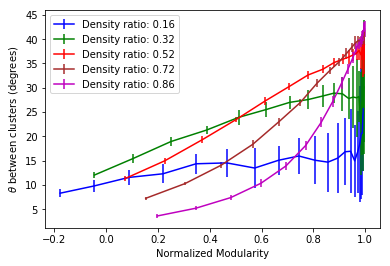

In [20]:
##### %%time
SAMPLES=30

size1 = 250
size2 = 250

edge2 = 20
colors = ['b','g','r','brown','m']
for j,edge1 in enumerate([3,6,10,14,17]):
    modu = np.empty((SAMPLES,20))
    angle = np.empty((SAMPLES,20))
    ratios = np.empty((SAMPLES,20))
    for i in range(SAMPLES):
        modularity = []
        angle_diff = []
        ratio = []
        for common_edges in np.logspace(1,np.log10(6000),20,dtype=int):
            #avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
            avgDeg1, avgDeg2, d1, d2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
            modularity.append(mod)
            #ratio.append(avgLcc1 / avgLcc2)
            ratio.append(d1 / d2)
            evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
            kc = (kc - np.min(kc)) / np.max(kc - np.min(kc))

            evc1 = evc[np.arange(size1)]
            evc2 = evc[np.arange(size2)+size1]
            kc1 = kc[np.arange(size1)]
            kc2 = kc[np.arange(size2)+size1]


            m1, b1, _,_,_ = linregress(evc1,kc1)
            m2,b2,_,_,_ = linregress(evc2,kc2)

            theta1 = np.arctan(m1)
            theta2 = np.arctan(m2)

            diff = np.abs(theta1-theta2)
            angle_diff.append(diff* (180 / np.pi))
        modu[i,:] = modularity
        angle[i,:] = angle_diff
        ratios[i,:] = ratio

    #plt.plot(np.mean(modu,axis=0),np.mean(angle,axis=0),c=colors[j],label='Avg LCC ratio: %.2f'%(ratio))
    plt.errorbar(np.mean(modu,axis=0),np.mean(angle,axis=0),yerr = np.std(angle,axis=0),
                 color=colors[j],label=r'Density ratio: %.2f'%(np.mean(ratios)))

plt.legend()
plt.xlabel('Normalized Modularity')
plt.ylabel(r'$\theta$ between clusters (degrees)')
plt.show()

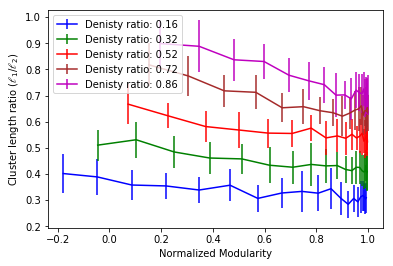

CPU times: user 4min 7s, sys: 210 ms, total: 4min 7s
Wall time: 4min 8s


In [21]:
%%time
SAMPLES=30

size1 = 250
size2 = 250

edge2 = 20
colors = ['b','g','r','brown','m']
j=-1
for edge1 in [3,6,10,14,17]:
    j+=1
    modu = np.empty((SAMPLES,20))
    length_rat = np.empty((SAMPLES,20))
    ratios = np.empty((SAMPLES,20))
    for i in range(SAMPLES):
        modularity = []
        length_ratio = []
        ratio = []
        for common_edges in np.logspace(1,np.log10(6000),20,dtype=int):
            #avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
            avgDeg1, avgDeg2, d1, d2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
            modularity.append(mod)
            ratio.append(d1 / d2)
            evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
            kc = (kc - np.min(kc)) / np.max(kc - np.min(kc))

            evc1 = evc[np.arange(size1)]
            evc2 = evc[np.arange(size2)+size1]
            kc1 = kc[np.arange(size1)]
            kc2 = kc[np.arange(size2)+size1]

            dist1 = np.linalg.norm([np.max(evc1)-np.min(evc1),np.max(kc1)-np.min(kc1)])
            dist2 = np.linalg.norm([np.max(evc2)-np.min(evc2),np.max(kc2)-np.min(kc2)])

            length_ratio.append(dist1/dist2)
        modu[i,:] = modularity
        length_rat[i,:] = length_ratio
        ratios[i,:] = ratio
    plt.errorbar(np.mean(modu,axis=0),np.mean(length_rat,axis=0),yerr=np.std(length_rat,axis=0),color=colors[j],
             label=r'Denisty ratio: %.2f'%(np.mean(ratios)))

plt.legend()
plt.xlabel('Normalized Modularity')
plt.ylabel(r'Cluster length ratio ($\mathscr{l}_1/\mathscr{l}_2$)')
plt.show()

In [22]:
def getCentroids(dfC1,dfC2):
    normedC1 = dfC1[['Katz','EVC']].apply(np.linalg.norm,axis=1)
    normedC2 = dfC2[['Katz','EVC']].apply(np.linalg.norm,axis=1)
    med1 = np.median(normedC1)
    med2 = np.median(normedC2)
    c1_centroid_idx = normedC1[normedC1<med1].index.values
    c2_centroid_idx = normedC2[normedC2<med2].index.values
    c1_centroid = dfC1.loc[c1_centroid_idx,:].mean().values
    c2_centroid = dfC2.loc[c2_centroid_idx,:].mean().values
    return c1_centroid, c2_centroid

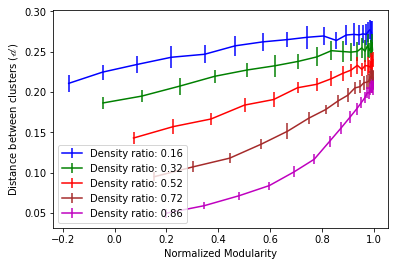

CPU times: user 5min 40s, sys: 194 ms, total: 5min 40s
Wall time: 5min 40s


In [25]:
%%time
SAMPLES=30

size1 = 250
size2 = 250

edge2 = 20
colors = ['b','g','r','brown','m']
j=-1
for edge1 in [3,6,10,14,17]:
    j+=1
    modu = np.empty((SAMPLES,20))
    dist = np.empty((SAMPLES,20))
    ratios = np.empty((SAMPLES,20))
    for i in range(SAMPLES):
        modularity = []
        dist_ = []
        ratio = []
        for common_edges in np.logspace(1,np.log10(6000),20,dtype=int):
            avgDeg1, avgDeg2, d1, d2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
            modularity.append(mod)
            ratio.append(d1 / d2)
            evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
            kc = (kc - np.min(kc)) / np.max(kc - np.min(kc))

            evc1 = evc[np.arange(size1)]
            evc2 = evc[np.arange(size2)+size1]
            kc1 = kc[np.arange(size1)]
            kc2 = kc[np.arange(size2)+size1]

            dfC1 = pd.DataFrame({'Katz':kc1,'EVC':evc1})
            dfC2 = pd.DataFrame({'Katz':kc2,'EVC':evc2})
            c1_centroid, c2_centroid = getCentroids(dfC1,dfC2)
            distance = np.linalg.norm(c1_centroid - c2_centroid)
            dist_.append(distance)
            
        modu[i,:] = modularity
        dist[i,:] = dist_
        ratios[i,:] = ratio

    plt.errorbar(np.mean(modu,axis=0),np.mean(dist,axis=0),yerr=np.std(dist,axis=0),color=colors[j],
             label='Density ratio: %.2f'%(np.mean(ratios)))

plt.legend()
plt.xlabel('Normalized Modularity')
plt.ylabel(r'Distance between clusters ($\mathscr{d}$)')
plt.show()